In [17]:
# Cell 1: Imports
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score
from medmnist import INFO
import medmnist


In [18]:
# Cell 2: Weight utilities

def weight_vec(network):
    A = []
    for w in network.parameters():
        A.append(torch.flatten(w))
    return torch.cat(A)

def weight_dec_global(pyModel, weight_vec): 
    c = 0
    for w in pyModel.parameters():
        m = w.numel()
        D = weight_vec[c:m+c].reshape(w.data.shape) 
        c += m
        with torch.no_grad():
            w.set_(D + 0)
    return pyModel


In [19]:
# Cell 3: Load BloodMNIST (MedMNIST)

# def load_bloodmnist(input_size=224, batch_size=32, download=True, num_workers=2):
#     data_flag = 'bloodmnist'
#     info = INFO[data_flag]
#     DataClass = getattr(medmnist, info['python_class'])

#     transform_train = transforms.Compose([
#         transforms.RandomVerticalFlip(),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
#         transforms.RandomResizedCrop(input_size, scale=(0.75, 1), ratio=(0.9, 1)),
#         transforms.ToTensor()
#     ])

#     transform_test = transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.ToTensor()
#     ])

#     train_dataset = DataClass(split='train', transform=transform_train, download=download)
#     test_dataset = DataClass(split='test', transform=transform_test, download=download)

#     return train_dataset, test_dataset


In [20]:
# Cell 4: BloodMNIST with optional subsampling

from collections import defaultdict
from torch.utils.data import Subset

def load_bloodmnist(
    input_size=224,
    batch_size=4,
    download=True,
    num_workers=2,
    subset_ratio=None,
    subset_size=None,
    subset_per_class=None,
    test_subset_size=None,
    seed=42
):
    data_flag = 'bloodmnist'
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])

    # Set seed for reproducibility
    np.random.seed(seed)

    transform_train = transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.RandomResizedCrop(input_size, scale=(0.75, 1), ratio=(0.9, 1)),
        transforms.ToTensor()
    ])

    transform_test = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor()
    ])

    # Full datasets
    train_dataset = DataClass(split='train', transform=transform_train, download=download)
    test_dataset = DataClass(split='test', transform=transform_test, download=download)

    # Apply subsampling
    if subset_ratio or subset_size or subset_per_class:
        targets = np.array(train_dataset.labels).squeeze()
        indices = []

        if subset_per_class:
            class_to_indices = defaultdict(list)
            for idx, label in enumerate(targets):
                class_to_indices[label].append(idx)
            for cls, cls_idxs in class_to_indices.items():
                selected = np.random.choice(cls_idxs, min(subset_per_class, len(cls_idxs)), replace=False)
                indices.extend(selected)

        elif subset_size:
            indices = np.random.choice(len(train_dataset), min(subset_size, len(train_dataset)), replace=False)

        elif subset_ratio:
            subset_size = int(len(train_dataset) * subset_ratio)
            indices = np.random.choice(len(train_dataset), subset_size, replace=False)

        train_dataset = Subset(train_dataset, indices)
        
    if test_subset_size:
        test_indices = np.random.choice(len(test_dataset), min(test_subset_size, len(test_dataset)), replace=False)
        test_dataset = Subset(test_dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=2*batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader, train_dataset, test_dataset


In [21]:
train_loader, test_loader, train_data, test_data = load_bloodmnist(
    input_size=224,
    batch_size=4,
    subset_per_class=10,  # 10 samples per class
    seed=105
)


Using downloaded and verified file: C:\Users\user\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\user\.medmnist\bloodmnist.npz


In [22]:
# Cell 5: MLP classification head

class MLPClassifier(nn.Module):
    def __init__(self, embed_dim=768, num_classes=8):
        super().__init__()
        self.norm = nn.LayerNorm((embed_dim,), eps=1e-6)
        self.fc = nn.Linear(in_features=embed_dim, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.norm(x)
        return self.fc(x)


In [23]:
# Cell 6: Residual Block (pseudo-class token distillation)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels=768, drop_out=0.5):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(14, stride=1)
        self.dropout = nn.Dropout2d(p=drop_out)

    def forward(self, x):
        # [B, N, C] → [B, C, 14, 14]
        if len(x.shape) == 3:
            x=x[:,1:,:]
            B,N,C = x.shape
            H = W = int(N**0.5)
            assert H*W == N,f"Cannot reshape {N} tokens to square grid"
            x = x.permute(0, 2, 1).reshape(B,C,H,W)
        residual = x
        out = self.conv1(x)
        out = self.dropout(out)
        out = self.conv2(out)
        out += residual
        out = self.relu(out)
        out = self.pool(out)
        return out.view(out.size(0), -1)  # flatten


In [24]:
# Cell 7: FeSViBS model

import timm
import copy

class FeSVBiS(nn.Module):
    def __init__(self, 
                 vit_name='vit_base_r50_s16_224',
                 num_classes=8,
                 num_clients=6,
                 in_channels=3,
                 pretrained=False,
                 initial_block=1,
                 final_block=6,
                 dropout=0.5,
                 dp=False,
                 mean=0.0,
                 std=1.0):
        super().__init__()
        self.initial_block = initial_block
        self.final_block = final_block
        self.dp = dp
        self.mean = mean
        self.std = std

        self.vit = timm.create_model(
            model_name=vit_name,
            pretrained=pretrained,
            num_classes=num_classes,
            in_chans=in_channels
        )

        # Shared body
        self.resnet50 = self.vit.patch_embed
        self.resnet50_clients = nn.ModuleList([
            copy.deepcopy(self.resnet50) for _ in range(num_clients)
        ])

        # Residual augmentation
        self.res_block = ResidualBlock(in_channels=768, drop_out=dropout)

        # Client-specific classifier
        self.classifier_heads = nn.ModuleList([
            MLPClassifier(embed_dim=768, num_classes=num_classes) for _ in range(num_clients)
        ])

    def forward(self, x, chosen_block, client_idx):
        x = self.resnet50_clients[client_idx](x)  # Patch Embedding
        if self.dp:
            noise = torch.randn_like(x).to(x.device) * self.std + self.mean
            x += noise

        # Add cls token and positional embeddings
        x = torch.cat((self.vit.cls_token.expand(x.size(0), -1, -1), x), dim=1)
        x = self.vit.pos_drop(x + self.vit.pos_embed)

        for i in range(chosen_block):
            x = self.vit.blocks[i](x)

        # Residual block and classifier
        x = self.res_block(x)
        out = self.classifier_heads[client_idx](x)
        return out


In [25]:
model = FeSVBiS(
    vit_name='vit_base_r50_s16_224',
    num_classes=8,
    num_clients=6,
    pretrained=False,
    initial_block=1,
    final_block=6,
    dp=True,
    mean=0,
    std=0.1
).cuda()


In [26]:
# Cell 8: Training controller for FeSViBS

class SplitFeSViBS:
    def __init__(self, model, num_clients, device, criterion, test_loader, initial_block, final_block):
        self.model = model.to(device)
        self.num_clients = num_clients
        self.device = device
        self.criterion = criterion
        self.initial_block = initial_block
        self.final_block = final_block
        self.test_loader = test_loader

        # These will be populated later
        self.client_loaders = []
        self.optimizer = None
        self.logs = {'train': [[] for _ in range(num_clients)], 'test': [[] for _ in range(num_clients)]}
        self.bal_acc = {'train': [[] for _ in range(num_clients)], 'test': [[] for _ in range(num_clients)]}
        self.chosen_blocks = [initial_block] * num_clients

    def set_client_loaders(self, client_loaders):
        self.client_loaders = client_loaders

    def set_optimizer(self, lr=1e-4):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train_client(self, client_idx):
        loader = self.client_loaders[client_idx]
        self.model.train()

        chosen_block = random.randint(self.initial_block, self.final_block)
        self.chosen_blocks[client_idx] = chosen_block
        print(f"Client {client_idx} uses block {chosen_block}")

        total_loss = 0
        all_preds, all_labels = [], []

        for imgs, labels in tqdm(loader, desc=f"Training Client {client_idx}"):
            imgs, labels = imgs.to(self.device), labels.to(self.device).view(-1)

            self.optimizer.zero_grad()
            outputs = self.model(imgs, chosen_block, client_idx)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        acc = balanced_accuracy_score(all_labels, all_preds)
        avg_loss = total_loss / len(loader)

        self.logs['train'][client_idx].append(avg_loss)
        self.bal_acc['train'][client_idx].append(acc)

        print(f"[Train] Client {client_idx} - Loss: {avg_loss:.4f}, Acc: {acc:.4f}")

    def eval_client(self, client_idx):
        self.model.eval()
        loader = self.test_loader
        chosen_block = self.chosen_blocks[client_idx]

        total_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for imgs, labels in tqdm(loader, desc=f"Evaluating Client {client_idx}"):
                imgs, labels = imgs.to(self.device), labels.to(self.device).view(-1)
                outputs = self.model(imgs, chosen_block, client_idx)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        acc = balanced_accuracy_score(all_labels, all_preds)
        avg_loss = total_loss / len(loader)

        self.logs['test'][client_idx].append(avg_loss)
        self.bal_acc['test'][client_idx].append(acc)

        print(f"[Eval] Client {client_idx} - Loss: {avg_loss:.4f}, Acc: {acc:.4f}")


In [27]:
# Cell 9: Aggregation utils for shared blocks, cls token, pos embedding, heads, and tails

def aggregate_transformer_weights(client_weights, device):
    agg = {
        'blocks': torch.stack([cw['blocks'] for cw in client_weights]).mean(0).to(device),
        'cls': torch.stack([cw['cls'] for cw in client_weights]).mean(0).to(device),
        'pos_embed': torch.stack([cw['pos_embed'] for cw in client_weights]).mean(0).to(device)
    }
    return agg


In [28]:
# Cell 10: Extract and store ViT block-related weights per client

def extract_vit_weights(model, device):
    return {
        'blocks': weight_vec(model.vit.blocks).detach().cpu(),
        'cls': model.vit.cls_token.detach().cpu(),
        'pos_embed': model.vit.pos_embed.detach().cpu()
    }


In [29]:
# Cell 11: Reassign averaged weights to ViT backbone (blocks + cls + pos_embed)

def apply_vit_weights(model, agg_weights, device):
    model.vit.blocks = weight_dec_global(model.vit.blocks, agg_weights['blocks'].to(device))
    model.vit.cls_token.data = agg_weights['cls'].to(device)
    model.vit.pos_embed.data = agg_weights['pos_embed'].to(device)


In [30]:
# Cell 12: Aggregate resnet patch embed (head) and MLP tail across all clients

def aggregate_heads_tails(model, num_clients, device):
    head_weights = []
    tail_weights = []

    for i in range(num_clients):
        head_weights.append(weight_vec(model.resnet50_clients[i]).detach().cpu())
        tail_weights.append(weight_vec(model.classifier_heads[i]).detach().cpu())

    mean_head = torch.mean(torch.stack(head_weights), dim=0)
    mean_tail = torch.mean(torch.stack(tail_weights), dim=0)

    for i in range(num_clients):
        model.resnet50_clients[i] = weight_dec_global(model.resnet50_clients[i], mean_head.to(device))
        model.classifier_heads[i] = weight_dec_global(model.classifier_heads[i], mean_tail.to(device))


In [31]:
# Cell 13: Full training loop

def run_fesvibs(
    model,
    split_controller,
    num_clients=6,
    epochs=2,
    local_round=2,
    save_every=1,
    device='cuda'
):
    for r in range(epochs):
        print(f"\n================= ROUND {r+1}/{epochs} =================")

        # Train each client
        client_weights = []
        for client_id in range(num_clients):
            split_controller.train_client(client_id)
            cw = extract_vit_weights(model, device)
            client_weights.append(cw)

        # Aggregate ViT body
        vit_avg = aggregate_transformer_weights(client_weights, device)
        apply_vit_weights(model, vit_avg, device)

        # Aggregate heads & tails every local_round
        if (r + 1) % local_round == 0:
            print("===> Aggregating client heads and tails...")
            aggregate_heads_tails(model, num_clients, device)

        # Evaluation for each client
        for client_id in range(num_clients):
            split_controller.eval_client(client_id)

        print("====================================================")


In [32]:
# Cell 14: Minimal FeSViBS execution on BloodMNIST subset

# Step 1: Load small subset of BloodMNIST
train_loader, test_loader, train_dataset, test_dataset = load_bloodmnist(
    input_size=224,
    batch_size=4,
    subset_per_class=10,  # 10 images per class for small test
    test_subset_size=20,
    seed=105
)

# Step 2: Split train dataset among clients (IID random split for now)
from torch.utils.data import random_split

def split_dataset_among_clients(dataset, num_clients):
    total_size = len(dataset)
    size_per_client = total_size // num_clients
    extras = total_size % num_clients
    sizes = [size_per_client + (1 if i < extras else 0) for i in range(num_clients)]
    return random_split(dataset, sizes)

num_clients = 6
client_subsets = split_dataset_among_clients(train_dataset, num_clients)
client_loaders = [DataLoader(subset, batch_size=4, shuffle=True) for subset in client_subsets]

# Step 3: Initialize model
model = FeSVBiS(
    vit_name='vit_base_r50_s16_224',
    num_classes=8,
    num_clients=num_clients,
    pretrained=False,
    initial_block=1,
    final_block=6,
    dp=False  # Set True for differential privacy
).to('cuda' if torch.cuda.is_available() else 'cpu')

# Step 4: Initialize training controller
device = 'cuda' if torch.cuda.is_available() else 'cpu'
split_trainer = SplitFeSViBS(
    model=model,
    num_clients=num_clients,
    device=device,
    criterion=nn.CrossEntropyLoss(),
    test_loader=test_loader,
    initial_block=1,
    final_block=6
)
split_trainer.set_client_loaders(client_loaders)
split_trainer.set_optimizer(lr=1e-4)

# Step 5: Run training
run_fesvibs(
    model=model,
    split_controller=split_trainer,
    num_clients=num_clients,
    epochs=2,
    local_round=1,
    save_every=1,
    device=device
)


Using downloaded and verified file: C:\Users\user\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\user\.medmnist\bloodmnist.npz

================= ROUND 1/2 =================
Client 0 uses block 5


Training Client 0: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


[Train] Client 0 - Loss: 3.5470, Acc: 0.1875
Client 1 uses block 1


Training Client 1: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


[Train] Client 1 - Loss: 2.6092, Acc: 0.2361
Client 2 uses block 5


Training Client 2: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Train] Client 2 - Loss: 2.5145, Acc: 0.1500
Client 3 uses block 3


Training Client 3: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


[Train] Client 3 - Loss: 1.7979, Acc: 0.1667
Client 4 uses block 4


Training Client 4: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


[Train] Client 4 - Loss: 2.4847, Acc: 0.0625
Client 5 uses block 4


Training Client 5: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


[Train] Client 5 - Loss: 2.0676, Acc: 0.1111
===> Aggregating client heads and tails...


Evaluating Client 0: 100%|██████████| 3/3 [00:15<00:00,  5.13s/it]


[Eval] Client 0 - Loss: 1.8973, Acc: 0.1429


Evaluating Client 1: 100%|██████████| 3/3 [00:10<00:00,  3.65s/it]


[Eval] Client 1 - Loss: 2.0363, Acc: 0.1429


Evaluating Client 2: 100%|██████████| 3/3 [00:13<00:00,  4.50s/it]


[Eval] Client 2 - Loss: 1.8973, Acc: 0.1429


Evaluating Client 3: 100%|██████████| 3/3 [00:12<00:00,  4.11s/it]


[Eval] Client 3 - Loss: 1.9014, Acc: 0.1429


Evaluating Client 4: 100%|██████████| 3/3 [00:13<00:00,  4.37s/it]


[Eval] Client 4 - Loss: 1.8928, Acc: 0.1429


Evaluating Client 5: 100%|██████████| 3/3 [00:13<00:00,  4.45s/it]


[Eval] Client 5 - Loss: 1.8928, Acc: 0.1429

================= ROUND 2/2 =================
Client 0 uses block 4


Training Client 0: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


[Train] Client 0 - Loss: 2.0719, Acc: 0.1250
Client 1 uses block 2


Training Client 1: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Train] Client 1 - Loss: 1.8921, Acc: 0.2222
Client 2 uses block 1


Training Client 2: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


[Train] Client 2 - Loss: 1.7953, Acc: 0.3667
Client 3 uses block 5


Training Client 3: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Train] Client 3 - Loss: 1.9646, Acc: 0.1250
Client 4 uses block 1


Training Client 4: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


[Train] Client 4 - Loss: 1.9463, Acc: 0.2500
Client 5 uses block 3


Training Client 5: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


[Train] Client 5 - Loss: 1.9525, Acc: 0.1667
===> Aggregating client heads and tails...


Evaluating Client 0: 100%|██████████| 3/3 [00:13<00:00,  4.47s/it]


[Eval] Client 0 - Loss: 1.8215, Acc: 0.3810


Evaluating Client 1: 100%|██████████| 3/3 [00:11<00:00,  3.90s/it]


[Eval] Client 1 - Loss: 1.8487, Acc: 0.4643


Evaluating Client 2: 100%|██████████| 3/3 [00:11<00:00,  3.69s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Eval] Client 2 - Loss: 1.9367, Acc: 0.2857


Evaluating Client 3: 100%|██████████| 3/3 [00:13<00:00,  4.56s/it]


[Eval] Client 3 - Loss: 1.8000, Acc: 0.2857


Evaluating Client 4: 100%|██████████| 3/3 [00:10<00:00,  3.60s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[Eval] Client 4 - Loss: 1.9367, Acc: 0.2857


Evaluating Client 5: 100%|██████████| 3/3 [00:12<00:00,  4.10s/it]

[Eval] Client 5 - Loss: 1.7808, Acc: 0.4048


In [33]:
# Cell 15: Plot loss and accuracy across rounds for each client

import matplotlib.pyplot as plt

def plot_metrics(split_trainer, metric='loss', max_rounds=None):
    assert metric in ['loss', 'acc'], "metric must be 'loss' or 'acc'"

    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    # Use the correct data source
    train_data = split_trainer.logs['train'] if metric == 'loss' else split_trainer.bal_acc['train']
    test_data = split_trainer.logs['test'] if metric == 'loss' else split_trainer.bal_acc['test']

    num_clients = len(train_data)
    rounds = max_rounds or len(train_data[0])

    # Plot training curves
    for i in range(num_clients):
        axs[0].plot(train_data[i][:rounds], label=f"Client {i}")
    axs[0].set_title(f"Training {'Loss' if metric == 'loss' else 'Accuracy'}")
    axs[0].set_xlabel("Rounds")
    axs[0].set_ylabel("Loss" if metric == 'loss' else "Balanced Accuracy")
    axs[0].legend()

    # Plot testing curves
    for i in range(num_clients):
        axs[1].plot(test_data[i][:rounds], label=f"Client {i}")
    axs[1].set_title(f"Testing {'Loss' if metric == 'loss' else 'Accuracy'}")
    axs[1].set_xlabel("Rounds")
    axs[1].set_ylabel("Loss" if metric == 'loss' else "Balanced Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


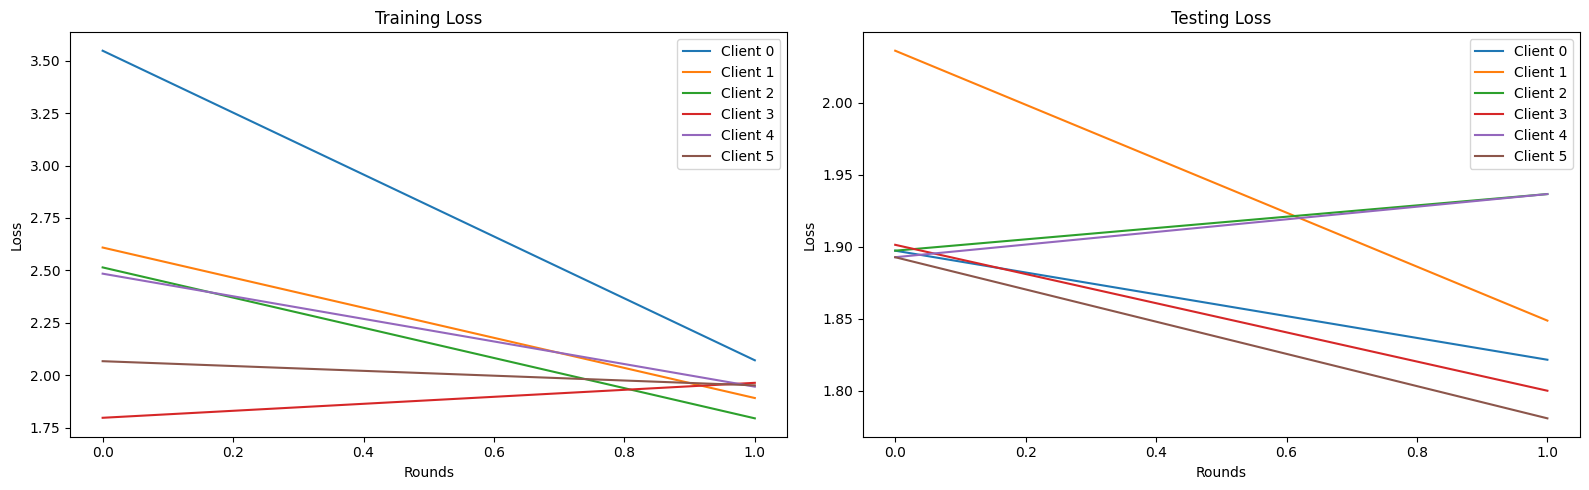

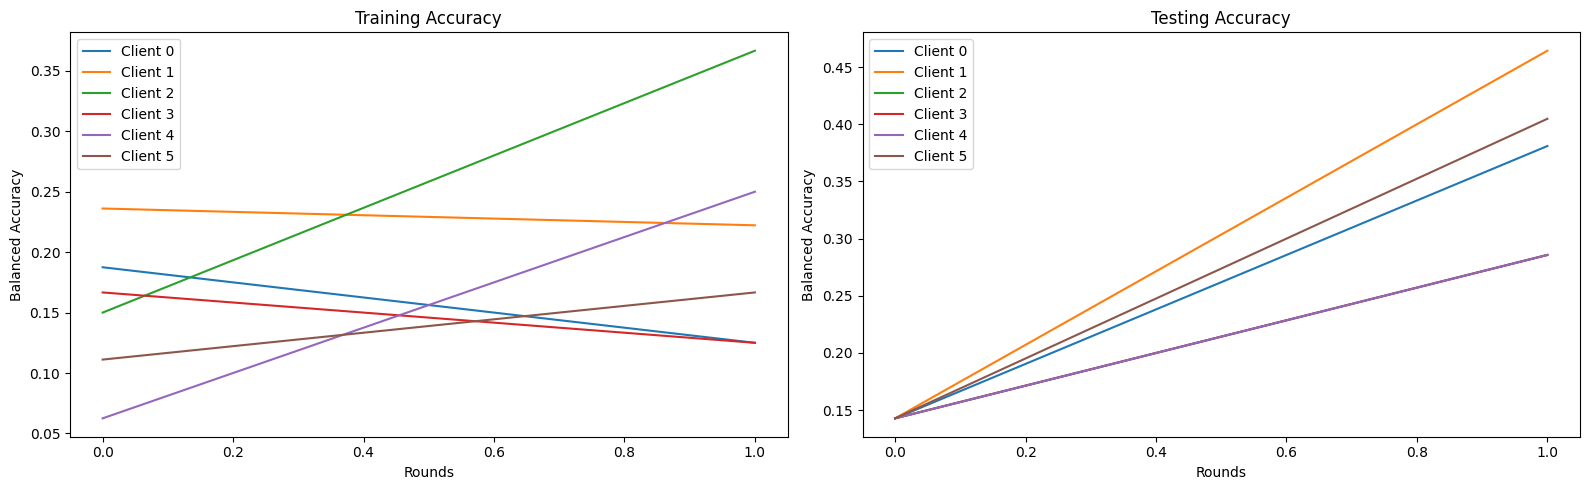

In [34]:
plot_metrics(split_trainer, metric='loss')
plot_metrics(split_trainer, metric='acc')
